In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from analysis import wl_accuracy, season_record, runs_per_game
from data_format import create_data

In [2]:
version = 6
df = pd.read_csv(f'./data/baseball/training/game_data_v{version}.csv')

In [5]:
x_train_away, x_test_away, y_train_away, y_test_away = create_data(df, y_col='away_score', split_by='season')
x_train_home, x_test_home, y_train_home, y_test_home = create_data(df, y_col='home_score', split_by='season')

In [6]:
model_away = RandomForestRegressor(n_estimators=3, max_features='sqrt')
model_home = RandomForestRegressor(n_estimators=3, max_features='sqrt')

model_away.fit(x_train_away, y_train_away)
model_home.fit(x_train_home, y_train_home)

pred_away = model_away.predict(x_test_away)
pred_home = model_home.predict(x_test_home)

results = pd.DataFrame({'away_pred': pred_away, 'home_pred': pred_home, 'away_true': y_test_away, 'home_true': y_test_home})
results.describe()

print('RANDOM FOREST REGRESSION MODEL (v2 - with increased variance)')
print(f'Accuracy: {wl_accuracy(results)}%')
print('-' * 30)
season_record(df, results)
print('-' * 30)
runs_per_game(df, results)

RANDOM FOREST REGRESSION MODEL (v2 - with increased variance)
Accuracy: 53.086419753086425%
------------------------------
Season records:
HOU: 110-52	LAD: 108-54	WSH: 104-58	NYY: 103-59	CLE: 102-60	
CHC: 98-64	AZ: 90-72	MIA: 89-73	MIN: 86-76	STL: 83-79	
SD: 80-82	LAA: 80-82	SF: 79-83	ATL: 79-83	BOS: 78-84	
COL: 76-86	BAL: 76-86	KC: 76-86	TOR: 75-87	PIT: 75-87	
SEA: 74-88	TEX: 74-88	OAK: 72-90	CIN: 72-90	TB: 71-91	
MIL: 70-92	NYM: 68-94	DET: 64-98	PHI: 59-103	CWS: 59-103	
------------------------------
Runs scored per game:
CLE: 5.75 (932)	HOU: 5.75 (931)	LAD: 5.42 (877)	NYY: 5.07 (821)	TEX: 4.97 (806)	
MIA: 4.95 (802)	CHC: 4.85 (786)	AZ: 4.82 (781)	LAA: 4.79 (776)	MIN: 4.78 (774)	
SEA: 4.75 (770)	ATL: 4.74 (768)	WSH: 4.69 (760)	KC: 4.64 (752)	TOR: 4.59 (743)	
PIT: 4.53 (734)	NYM: 4.52 (732)	SF: 4.51 (730)	BOS: 4.45 (722)	BAL: 4.42 (717)	
STL: 4.3 (696)	SD: 4.27 (691)	COL: 4.26 (690)	DET: 4.23 (685)	MIL: 4.22 (684)	
OAK: 4.22 (683)	CWS: 4.21 (682)	PHI: 4.2 (681)	TB: 4.07 (660)	CIN: 3.8

By using fewer decision trees, the aggregate records came out to be more realistic - even if it did come at the cost of losing some accuracy. Looking at the histogram below, we can see that this modified version has a mean accuracy of about 53%, which is still better than a random guessing model.

                0
count  100.000000
mean    53.006996
std      1.054244
min     50.205761
25%     52.294239
50%     53.127572
75%     53.621399
max     55.555556


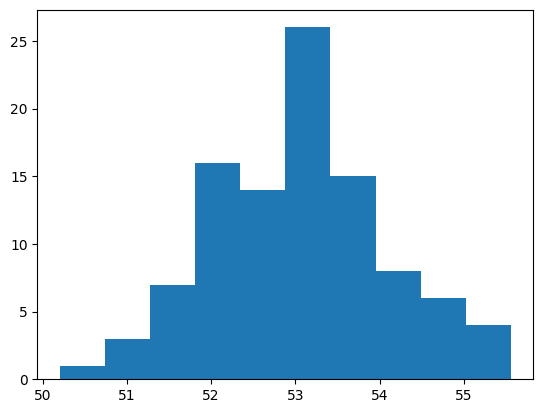

In [7]:
acc = []

for i in range(100):
    model_away.fit(x_train_away, y_train_away)
    model_home.fit(x_train_home, y_train_home)
    
    pred_away = model_away.predict(x_test_away)
    pred_home = model_home.predict(x_test_home)
    
    results = pd.DataFrame({'away_pred': pred_away, 'home_pred': pred_home, 'away_true': y_test_away, 'home_true': y_test_home})
    results.describe()
    
    acc.append(wl_accuracy(results))


print(pd.DataFrame(acc).describe())

plt.hist(acc)
plt.show()

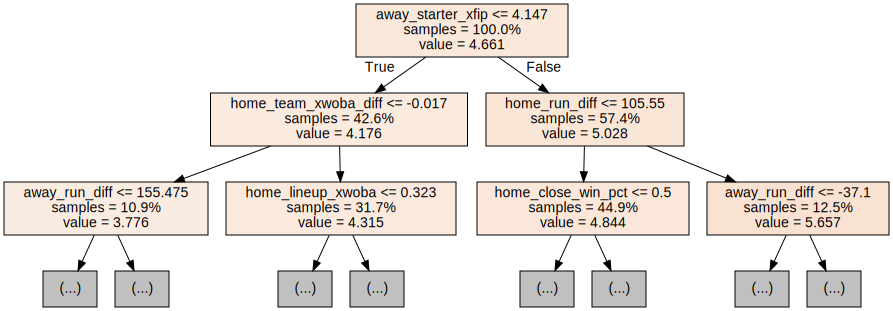

In [8]:
visualize_decision_trees(model_home, x_test_home.columns)